In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import json
import os
import shutil
from sklearn.model_selection import train_test_split
import numpy as np

# --- 1. CONFIGURATION ---
# Please double-check these paths are correct
COCO_ANNOTATIONS_FILE = '/content/drive/MyDrive/assets/assets/coco_dataset/annotations/annotations.coco.json'
COCO_IMAGES_DIR = '/content/drive/MyDrive/assets/assets/coco_dataset/images'

# This is where the new dataset will be created
OUTPUT_DIR = '/content/drive/MyDrive/assets/assets/coco_dataset/floorplan_yolo_dataset_detect'

# --- 2. CLEAN & CREATE DIRECTORIES ---
if os.path.exists(OUTPUT_DIR):
    shutil.rmtree(OUTPUT_DIR)

os.makedirs(os.path.join(OUTPUT_DIR, 'images', 'train'), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, 'images', 'val'), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, 'labels', 'train'), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, 'labels', 'val'), exist_ok=True)

print(f"Created new directory structure at: {OUTPUT_DIR}")

# --- 3. LOAD COCO JSON ---
with open(COCO_ANNOTATIONS_FILE, 'r') as f:
    coco_data = json.load(f)

print(f"Loaded {COCO_ANNOTATIONS_FILE}")

# --- 4. CREATE MAPPINGS & FILTER ANNOTATIONS ---
images = {img['id']: img for img in coco_data['images']}
categories = {cat['id']: cat['name'] for cat in coco_data['categories']}
class_names = list(categories.values())

# Group annotations by image ID
annotations_by_image = {}
valid_image_ids = set()
for ann in coco_data.get('annotations', []):

    # --- THIS IS THE FIX ---
    # We check if 'bbox' exists and is not empty.
    if 'bbox' in ann and ann['bbox']:
        img_id = ann['image_id']
        if img_id not in annotations_by_image:
            annotations_by_image[img_id] = []
        annotations_by_image[img_id].append(ann)
        valid_image_ids.add(img_id)
    # -----------------------

print(f"Found {len(images)} images total.")
print(f"Found {len(valid_image_ids)} images with valid bounding box annotations.")

# --- 5. SPLIT DATA (80% Train, 20% Val) ---
image_ids = list(valid_image_ids) # Only split images that have labels
train_ids, val_ids = train_test_split(image_ids, test_size=0.2, random_state=42)
print(f"Splitting {len(image_ids)} annotated images: {len(train_ids)} train, {len(val_ids)} val.")

# --- 6. CONVERSION FUNCTION ---
def convert_and_save(image_ids_set, split_name):
    num_processed = 0
    for img_id in image_ids_set:
        if img_id not in images:
            print(f"Warning: Image ID {img_id} not in image list. Skipping.")
            continue

        img_data = images[img_id]
        img_w = img_data['width']
        img_h = img_data['height']
        file_name = img_data['file_name']

        # Define paths
        label_path = os.path.join(OUTPUT_DIR, 'labels', split_name, os.path.splitext(file_name)[0] + '.txt')
        image_path = os.path.join(COCO_IMAGES_DIR, file_name)
        new_image_path = os.path.join(OUTPUT_DIR, 'images', split_name, file_name)

        # Copy image
        if not os.path.exists(image_path):
            print(f"Warning: Image file not found {image_path}. Skipping.")
            continue
        shutil.copy(image_path, new_image_path)
        num_processed += 1

        # Create label file
        with open(label_path, 'w') as f:
            if img_id in annotations_by_image:
                for ann in annotations_by_image[img_id]:
                    # Get class index
                    class_name = categories[ann['category_id']]
                    class_index = class_names.index(class_name)

                    # Get COCO bbox [x_min, y_min, width, height]
                    bbox = ann['bbox']
                    x_min, y_min, w, h = bbox

                    # Convert to YOLO format [x_center, y_center, width, height] (all normalized)
                    x_center_norm = (x_min + w / 2) / img_w
                    y_center_norm = (y_min + h / 2) / img_h
                    width_norm = w / img_w
                    height_norm = h / img_h

                    # Format as string: class_index x_center y_center w_norm h_norm
                    f.write(f"{class_index} {x_center_norm:.6f} {y_center_norm:.6f} {width_norm:.6f} {height_norm:.6f}\n")
    return num_processed

# --- 7. RUN CONVERSION ---
print("Converting train set...")
train_count = convert_and_save(train_ids, 'train')
print(f"Converted {train_count} train images.")

print("Converting val set...")
val_count = convert_and_save(val_ids, 'val')
print(f"Converted {val_count} val images.")

# --- 8. CREATE data.yaml ---
data_yaml_path = os.path.join(OUTPUT_DIR, 'data.yaml')
yaml_content = f"""
path: {os.path.abspath(OUTPUT_DIR)}
train: images/train
val: images/val

# Class names
names:
"""
for i, name in enumerate(class_names):
    yaml_content += f"  {i}: {name}\n"

with open(data_yaml_path, 'w') as f:
    f.write(yaml_content)

print("--- SUCCESS ---")
print(f"YOLO dataset created at: {OUTPUT_DIR}")
print(f"Your data.yaml file is at: {data_yaml_path}")

Created new directory structure at: /content/drive/MyDrive/assets/assets/coco_dataset/floorplan_yolo_dataset_detect
Loaded /content/drive/MyDrive/assets/assets/coco_dataset/annotations/annotations.coco.json
Found 545 images total.
Found 545 images with valid bounding box annotations.
Splitting 545 annotated images: 436 train, 109 val.
Converting train set...
Converted 436 train images.
Converting val set...
Converted 109 val images.
--- SUCCESS ---
YOLO dataset created at: /content/drive/MyDrive/assets/assets/coco_dataset/floorplan_yolo_dataset_detect
Your data.yaml file is at: /content/drive/MyDrive/assets/assets/coco_dataset/floorplan_yolo_dataset_detect/data.yaml


In [3]:
!pip install ultralytics
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 35.8 MB/s eta 0:00:00


In [5]:
from ultralytics import YOLO
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# 1. Load the 'small' SOTA DETECTION ARCHITECTURE (from scratch)
model = YOLO('yolov8s.yaml')  # 's' is for small

# 2. Train the model
data_yaml_path = '/content/drive/MyDrive/assets/assets/coco_dataset/floorplan_yolo_dataset_detect/data.yaml'

print(f"Starting training on {data_yaml_path}...")

results = model.train(
    data=data_yaml_path,
    epochs=300,  # <-- Increased to 300
    imgsz=640,
    device=device,
    name='floorplan_yolo_detect_small_300e' # New run name
)

print("Training complete.")

Using device: cuda
Starting training on /content/drive/MyDrive/assets/assets/coco_dataset/floorplan_yolo_dataset_detect/data.yaml...
Ultralytics 8.3.226 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/assets/assets/coco_dataset/floorplan_yolo_dataset_detect/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=300, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.ya

In [6]:
import shutil
import os

# Define the source path of the best model weights
# This path comes from the output of the previous training cell
SOURCE_WEIGHTS_PATH = '/content/runs/detect/floorplan_yolo_detect_small_300e2/weights/best.pt'

# Define the destination directory in Google Drive
# Make sure this directory exists or create it if necessary
DESTINATION_DIR = '/content/drive/MyDrive/assets/assets/'

# Ensure the destination directory exists
os.makedirs(DESTINATION_DIR, exist_ok=True)

# Copy the file
try:
    shutil.copy(SOURCE_WEIGHTS_PATH, DESTINATION_DIR)
    print(f"Successfully copied '{SOURCE_WEIGHTS_PATH}' to '{DESTINATION_DIR}'")
except FileNotFoundError:
    print(f"Error: Source file not found at '{SOURCE_WEIGHTS_PATH}'")
except Exception as e:
    print(f"An error occurred while copying the file: {e}")


Successfully copied '/content/runs/detect/floorplan_yolo_detect_small_300e2/weights/best.pt' to '/content/drive/MyDrive/assets/assets/'


In [7]:
# 1. Install EasyOCR (only need to run this once)
!pip install easyocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.8/963.8 kB 79.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.6/300.6 kB 29.2 MB/s eta 0:00:00


Loading YOLO model from /content/drive/MyDrive/assets/assets/best.pt...
Loading OCR model (EasyOCR)...
OCR model loaded.

0: 640x640 10 room_names, 5 clgs, 1 floor_name, 1 hor_dim, 11 room_dims, 20.2ms
Speed: 2.1ms preprocess, 20.2ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

Image: 0_18_jpg.rf.6cee1a21c69b4d0de5bc74e9516b6562.jpg
  > Detected label 'room_name' -> OCR Text: 'living rm'
  > Detected label 'room_name' -> OCR Text: 'garage'
  > Detected label 'room_name' -> OCR Text: 'coverfd'
  > Detected label 'room_name' -> OCR Text: 'patio'
  > Detected label 'room_name' -> OCR Text: 'wbedrm'

0: 640x640 14 room_names, 7 room_dims, 28.5ms
Speed: 3.3ms preprocess, 28.5ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 640)

Image: 14_29_jpg.rf.e5d77472d829f502782ddaa624897a3f.jpg
  > Detected label 'room_name' -> OCR Text: 'bath'
  > Detected label 'room_name' -> OCR Text: 'br'
  > Detected label 'room_name' -> OCR Text: 'hall'
  > Detected label 'roo

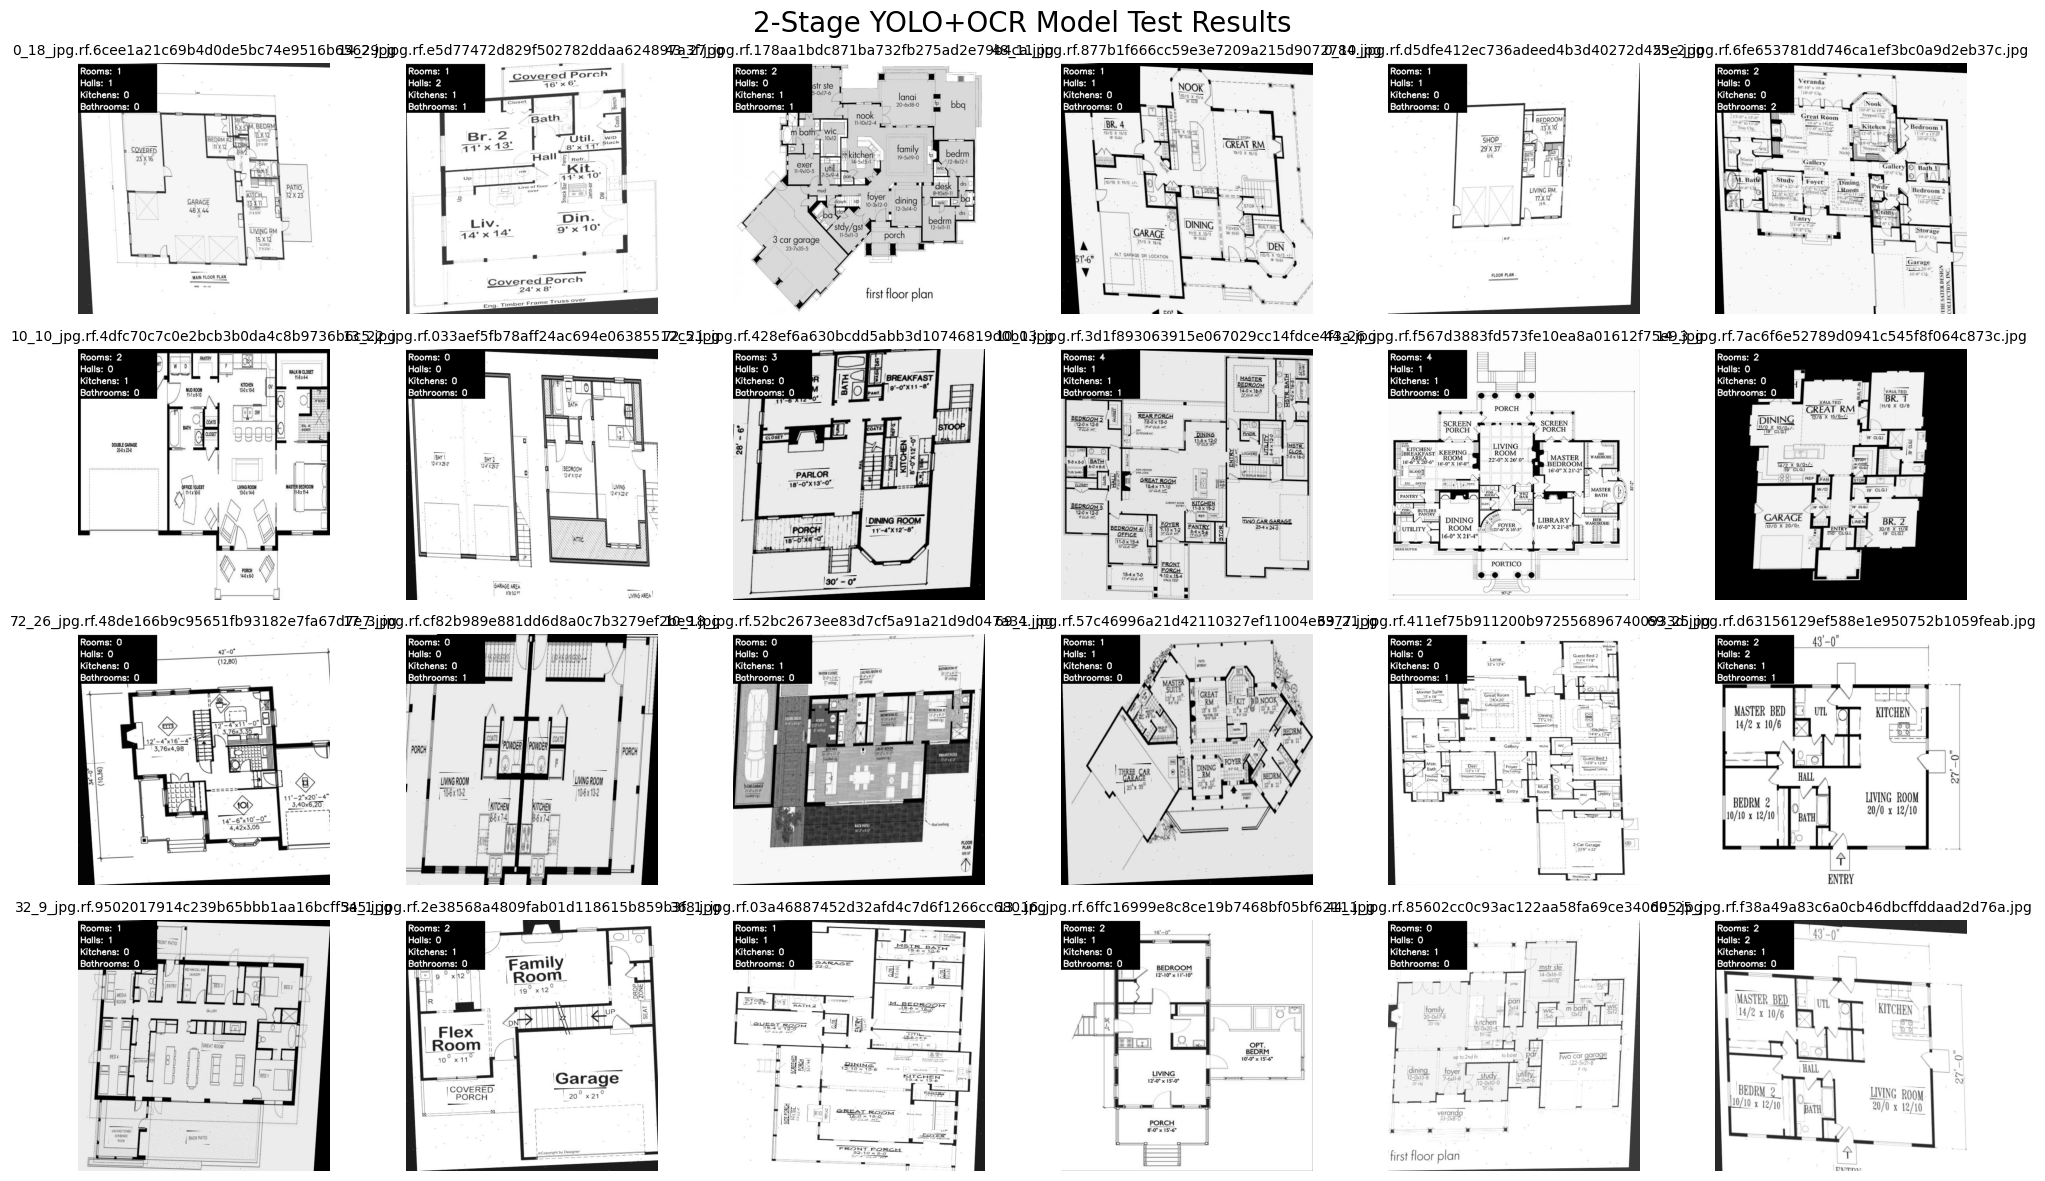

In [17]:


import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from PIL import Image
import json
import easyocr
import re # For cleaning text

# --- 2. Define the 2-Stage Parsing Function ---

# Initialize models as global so they only load once
yolo_model = None
ocr_reader = None

def parse_floorplan_with_ocr(local_image_path: str) -> dict:
    """
    Parses a floorplan image using a 2-stage (YOLO+OCR) pipeline.
    1. YOLO detects 'room_name' bounding boxes.
    2. OCR reads the text inside each box to classify the room.
    """
    global yolo_model, ocr_reader

    # --- Lazy-load YOLO model ---
    if yolo_model is None:
        # --- !! IMPORTANT !! ---
        # Update this path to your LATEST trained model
        MODEL_PATH = '/content/drive/MyDrive/assets/assets/best.pt'
        print(f"Loading YOLO model from {MODEL_PATH}...")
        yolo_model = YOLO(MODEL_PATH)

    # --- Lazy-load OCR model ---
    if ocr_reader is None:
        print("Loading OCR model (EasyOCR)...")
        # This will download the model the first time you run it
        ocr_reader = easyocr.Reader(['en'])
        print("OCR model loaded.")

    if not os.path.exists(local_image_path):
        print(f"Error: Image file not found at {local_image_path}")
        return {"error": f"Image file not found: {local_image_path}"}

    # Load the full image with PIL (better for cropping)
    img_pil = Image.open(local_image_path).convert("RGB")

    # Run YOLO detection
    results = yolo_model.predict(img_pil, imgsz=640, conf=0.25)
    result = results[0]

    # Initialize counts for the required categories
    counts = {
        "rooms": 0,
        "halls": 0,
        "kitchens": 0,
        "bathrooms": 0
    }

    class_names = result.names

    if result.boxes is not None:
        print(f"\nImage: {os.path.basename(local_image_path)}")
        for box in result.boxes:
            class_id = int(box.cls[0])
            label = class_names[class_id]

            # We only care about the 'room_name' labels for counting
            if label == 'room_name':
                # Get coordinates
                coords = box.xyxy[0].cpu().numpy().astype(int)
                x1, y1, x2, y2 = coords

                # Crop the image to the bounding box
                cropped_img_pil = img_pil.crop((x1, y1, x2, y2))
                # Convert PIL image to NumPy array for EasyOCR
                cropped_img_np = np.array(cropped_img_pil)

                # Run OCR on the cropped image
                ocr_result_list = ocr_reader.readtext(cropped_img_np, detail=0)

                if ocr_result_list:
                    # Clean the detected text
                    detected_text = " ".join(ocr_result_list).lower()
                    detected_text = re.sub(r'[^a-z\s]', '', detected_text).strip()

                    print(f"  > Detected label '{label}' -> OCR Text: '{detected_text}'")

                    # --- Simple classification based on text ---
                    if "ki" in detected_text:
                        counts["kitchens"] += 1
                    elif "bath" in detected_text or "wc" in detected_text or "wash" in detected_text or "toi" in detected_text or "powder" in detected_text:
                        counts["bathrooms"] += 1
                    elif "hall" in detected_text or "liv" in detected_text or "great" in detected_text:
                        counts["halls"] += 1
                    elif "bed" in detected_text or "room" in detected_text or "br" in detected_text:
                        # This is a general "room", e.g., bedroom
                        counts["rooms"] += 1

    json_output = {
        "rooms": counts["rooms"],
        "halls": counts["halls"],
        "kitchens": counts["kitchens"],
        "bathrooms": counts["bathrooms"],
        "rooms_detail": [] # This logic can be added back using 'room_dim'
    }

    return json_output

# --- 3. Load 6 Test Images ---
# Update this path to your validation image folder
validation_image_dir = '/content/drive/MyDrive/assets/assets/coco_dataset/floorplan_yolo_dataset_detect/images/val'
image_paths = glob.glob(os.path.join(validation_image_dir, '*.jpg'))[:24]

if len(image_paths) < 24:
    print(f"Warning: Found only {len(image_paths)} images. Adjusting plot size.")
    num_images = len(image_paths)
    if num_images == 0:
        print("Error: No images found. Check your path.")
else:
    num_images = 24

# --- 4. Create the Plot ---
fig, axes = plt.subplots(4, 6, figsize=(20, 12))
fig.suptitle('2-Stage YOLO+OCR Model Test Results', fontsize=20)
axes = axes.flatten() # Make it easy to iterate

for i in range(num_images):
    img_path = image_paths[i]

    # Run parsing
    data = parse_floorplan_with_ocr(img_path)

    # Load image with OpenCV for drawing
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Create the text to display
    text = (f"Rooms: {data.get('rooms', 0)}\n"
            f"Halls: {data.get('halls', 0)}\n"
            f"Kitchens: {data.get('kitchens', 0)}\n"
            f"Bathrooms: {data.get('bathrooms', 0)}")

    # Add text to the image
    y0, dy = 30, 30
    for j, line in enumerate(text.split('\n')):
        y = y0 + j * dy
        # Add a black rectangle for text background
        cv2.rectangle(img, (0, y-25), (200, y+8), (0,0,0), -1)
        # Add the white text
        cv2.putText(img, line, (5, y), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

    # Display the image in the subplot
    axes[i].imshow(img)
    axes[i].set_title(os.path.basename(img_path), fontsize=10)
    axes[i].axis('off')

# Hide any unused subplots
for j in range(num_images, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()